## Import required libraries

In [1]:
# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn import metrics

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline
from timeit import default_timer as timer
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller



# time series analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

In [2]:
from statsmodels.tsa.stattools import grangercausalitytests

## read Ice-creame_Vs_Heater dataset

In [3]:
df = pd.read_csv("ice-creame_vs_heater.csv")
df.head()

,Month,heater,ice cream
0,2004-01,27,13
1,2004-02,18,15
2,2004-03,14,16
3,2004-04,13,19
4,2004-05,13,21


## convert data into time series

In [4]:
df['date'] =pd.to_datetime(df['Month'])

In [5]:
df.dtypes

Month                object
heater                int64
ice cream             int64
date         datetime64[ns]
dtype: object

In [6]:
df.set_index('date',inplace=True)

In [7]:
df.drop('Month',axis=1,inplace=True)
df.head()

,heater,ice cream
date,,
2004-01-01,27,13
2004-02-01,18,15
2004-03-01,14,16
2004-04-01,13,19
2004-05-01,13,21


## plot the time series

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,8

<AxesSubplot:xlabel='date'>

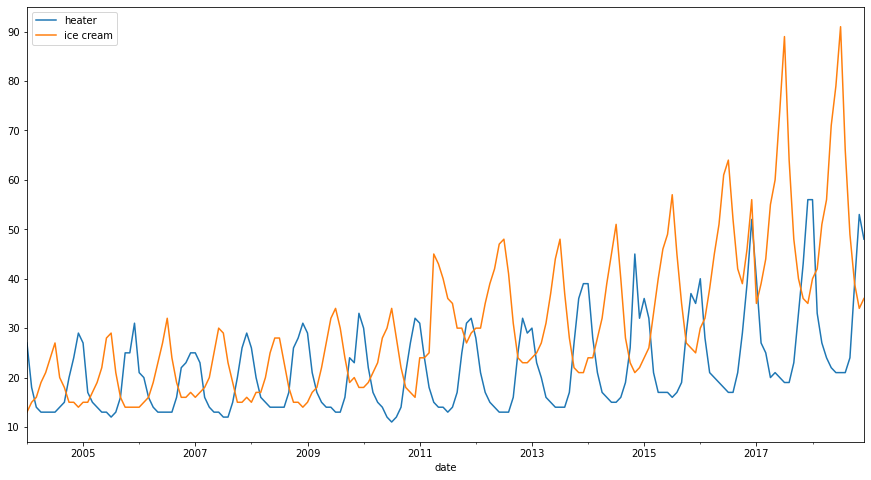

In [9]:
df.plot()


## establish the presence of a statistically significant connection between ice-cream and heater time series using Cointegration test for alpha= 0.05.

In [11]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)   

,heater_x,ice cream_x
heater_y,1.0,0.0
ice cream_y,0.0,1.0


If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

grangercausalitytests indicate there exists significant cointegration between heater and ice_cream sales and the time series graph shows neagitive relation

In [12]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
heater ::  43.54     > 12.3212   =>   True
ice cream ::  8.28      > 4.1296    =>   True


## split the series into training and testing sets

In [16]:
nobs = 0.3
df_train, df_test = df[0:int(-nobs*len(df))], df[int(-nobs*len(df)):]

# Check size
print(df_train.shape)  
print(df_test.shape) 

(126, 2)
(54, 2)


## check for stationarity

In [17]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [18]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "heater" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.7025
 No. Lags Chosen       = 12
 Critical value 1%     = -3.49
 Critical value 5%     = -2.887
 Critical value 10%    = -2.581
 => P-Value = 0.9899. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ice cream" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.8795
 No. Lags Chosen       = 13
 Critical value 1%     = -3.49
 Critical value 5%     = -2.888
 Critical value 10%    = -2.581
 => P-Value = 0.7947. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




## If series is not stationary, use differencing to make the series stationary

In [19]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [20]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "heater" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.0708
 No. Lags Chosen       = 11
 Critical value 1%     = -3.49
 Critical value 5%     = -2.887
 Critical value 10%    = -2.581
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ice cream" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.818
 No. Lags Chosen       = 13
 Critical value 1%     = -3.491
 Critical value 5%     = -2.888
 Critical value 10%    = -2.581
 => P-Value = 0.0558. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




In [21]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [22]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "heater" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.2816
 No. Lags Chosen       = 13
 Critical value 1%     = -3.491
 Critical value 5%     = -2.888
 Critical value 10%    = -2.581
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ice cream" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.5614
 No. Lags Chosen       = 13
 Critical value 1%     = -3.491
 Critical value 5%     = -2.888
 Critical value 10%    = -2.581
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




##  select the right order of the VAR model for least AIC.

In [24]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic


In [31]:
dfObj1 = pd.DataFrame(columns=['param', 'AIC'])
dfObj1

,param,AIC


In [32]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    dfObj1 = dfObj1.append({'param':i, 'AIC': result.aic}, ignore_index=True)
    

In [33]:
dfObj1.sort_values(by=['AIC'])

,param,AIC
10,11.0,3.918943
11,12.0,3.935659
9,10.0,4.362447
8,9.0,4.540740
7,8.0,4.643387
6,7.0,4.747937
5,6.0,4.907337
4,5.0,5.136321
3,4.0,5.542317
2,3.0,5.773066


## Train the VAR model for selected order

In [34]:
model_fitted = model.fit(11)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 17, Jul, 2022
Time:                     21:38:25
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    5.02921
Nobs:                     113.000    HQIC:                   4.36948
Log likelihood:          -496.100    FPE:                    50.9311
AIC:                      3.91894    Det(Omega_mle):         35.1611
--------------------------------------------------------------------
Results for equation heater
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.015555         0.189352           -0.082           0.935
L1.heater            -1.306982         0.083073          -15.733           0.000
L1.ice cream         -0.039410         0.070034           -

In [36]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

heater : 2.16
ice cream : 2.05


## forecast using fitted model

In [37]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

11


array([[  0., -15.],
       [  3.,   2.],
       [  7.,   3.],
       [ -1.,   5.],
       [ -6.,   1.],
       [ -3.,   3.],
       [-11.,  -3.],
       [  4.,   4.],
       [  3.,   0.],
       [  3.,   3.],
       [  0.,  -1.]])

In [42]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=int(nobs*len(df)))
df_forecast = pd.DataFrame(fc, index=df.index[int(-nobs*len(df)):], columns=df.columns + '_2d')
df_forecast

,heater_2d,ice cream_2d
date,,
2014-07-01,0.598859,-5.436203
2014-08-01,0.457932,-7.633074
2014-09-01,4.402797,-2.348633
2014-10-01,5.714662,2.932558
2014-11-01,-1.809106,3.270585
2014-12-01,-4.088662,4.341594
2015-01-01,-6.977239,0.962876
2015-02-01,-6.954265,-0.281588
2015-03-01,2.235290,0.807662


## If differencing is done, Invert the transformation to get the real forecast

In [43]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [45]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['heater_forecast', 'ice cream_forecast']]

,heater_forecast,ice cream_forecast
date,,
2014-07-01,14.598859,45.563797
2014-08-01,14.655649,38.494520
2014-09-01,19.115237,29.076610
2014-10-01,29.289487,22.591258
2014-11-01,37.654631,19.376491
2014-12-01,41.931113,20.503319
2015-01-01,39.230357,22.593023
2015-02-01,29.575335,24.401139
2015-03-01,22.155604,27.016917


## plot the results

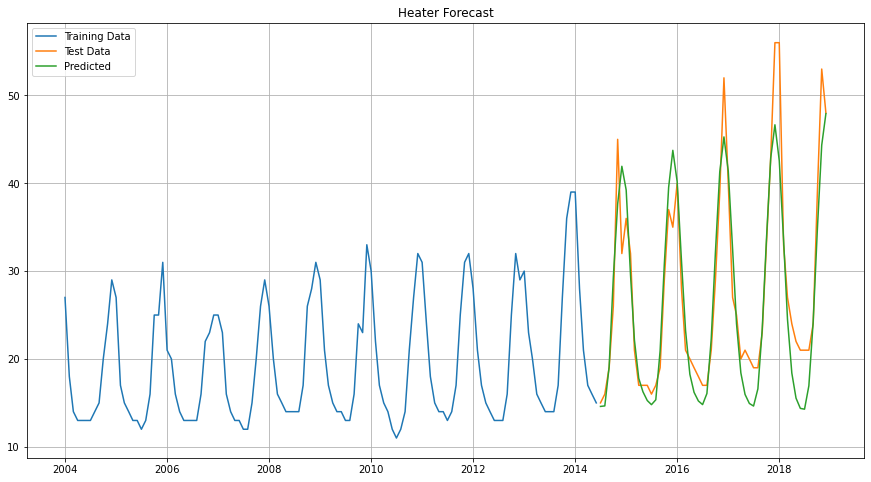

In [54]:
plt.plot(df_train['heater'],label='Training Data')
plt.plot(df_test['heater'],label='Test Data')
plt.plot(df_results['heater_forecast'],label='Predicted')
plt.title("Heater Forecast")
plt.legend(loc='best')
plt.grid();

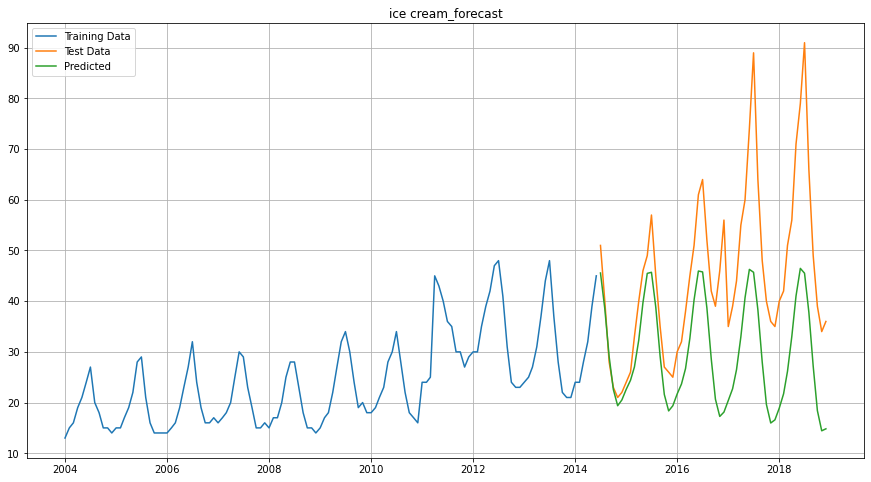

In [56]:
plt.plot(df_train['ice cream'],label='Training Data')
plt.plot(df_test['ice cream'],label='Test Data')
plt.plot(df_results['ice cream_forecast'],label='Predicted')
plt.title("ice cream_forecast")
plt.legend(loc='best')
plt.grid();

In [58]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})



In [60]:
print('Forecast Accuracy of: heater')
accuracy_prod = forecast_accuracy(df_results['heater_forecast'].values, df_test['heater'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: heater
mape :  0.1173
me :  -1.2371
mae :  3.2525
mpe :  -0.0481
rmse :  4.3881
corr :  0.929
minmax :  0.1128


In [61]:
print('Forecast Accuracy of: ice cream')
accuracy_prod = forecast_accuracy(df_results['ice cream_forecast'].values, df_test['ice cream'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: ice cream
mape :  0.3241
me :  -15.6978
mae :  15.7377
mpe :  -0.3226
rmse :  19.0565
corr :  0.7558
minmax :  0.324


## END